## File to create spatial dataset
Jameson Carter

purpose: To recompute the number of commercial buildings according to the zoning maps, as well as estimate whether buildings contain multiple units- this came from the realization that many apartment buildings are listed as commercial in the input data when they are not.

input: pittsburgh_footprint.shp
       sourced from:
       https://openac-alcogis.opendata.arcgis.com/datasets/AlCoGIS::allegheny-county-building-footprint-locations/explore?filters=eyJDTEFTUyI6WyJSIl19&location=40.462063%2C-79.916146%2C16.82
       and city of Pittsburgh 2010 census tract boundaries: https://data.wprdc.org/dataset/2010-census-tracts; additionally we using the zoning map from WPRDC: https://data.wprdc.org/dataset/zoning/resource/58428979-645f-413e-83b5-f06686c40959?inner_span=True. Grocery stores are obtained here: 
https://data.wprdc.org/dataset/allegheny-county-assets 
       
pittsburgh_footprint.shp merged from 'Filter footprints for Pittsburgh.ipynb'
       
output: pittsburgh_footprint_clean.shp

#### 1. Import footprint and relevant zones

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
footprint = gpd.read_file('C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/processed_data/pittsburgh_footprint.shp')

In [3]:
zones = gpd.read_file('C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/input_data/spatial_data/Zoning.shp')

#### 2. Get relevant zones and merge to the building footprints

Next, we have to get the relevant zones we are using to approximate whether a building is truly commercial, an apartment building, a 1-unit building, a 2-unit building, or a 3-unit building.

In [4]:
relevant_zones = zones.loc[zones['legendtype'].isin(['Local Neighborhood Commercial', 'Highway Commercial', 'Urban Neighborhood Commercial',
                                                     'Multi-Unit Residential','Single-Unit Attached Residential','Single-Unit Detached Residential',
                                                     'Two-Unit Residential','Three-Unit Residential'])] # Select zones
relevant_zones = relevant_zones[['geometry','legendtype']] # Restrict columns

zones['legendtype'].unique() # What are the zones, even? Note that this method misses specially zoned areas, downtown, and riverfront zoning... 

array(['Parks', 'Local Neighborhood Commercial', 'Highway Commercial',
       'Single-Unit Detached Residential', 'Urban Industrial',
       'Planned Unit Development', 'Neighborhood Industrial',
       'Two-Unit Residential', 'Multi-Unit Residential', 'Hillside',
       'Single-Unit Attached Residential', 'Mount Oliver Borough',
       'Three-Unit Residential', 'General Industrial',
       'Oakland Public Realm', 'Specially Planned', 'Golden Triangle',
       'Neighborhood Office', 'Urban Neighborhood Commercial',
       'Grandview Public Realm', 'Uptown Public Realm', 'Riverfront',
       'Educational/Medical Institution', 'Urban Center'], dtype=object)

In [5]:
footprint_zones = footprint.sjoin(relevant_zones, how="left", predicate='intersects')
footprint_zones['CLASS'].unique()

array(['C', 'R', 'G', 'U', 'I', 'F', 'O', None, 'None'], dtype=object)

#### 3. Recode classes of polygons according to the zones they fall in
What I need from the below is the following: a re-coded class for these footprints such that only those WITHIN commercial zoning boundaries count as commercial. Going to recode them from commercial to 'maybe_commercial_or_apartment'. Also, will recode residnetial buildings according to their zoning district.

<AxesSubplot:>

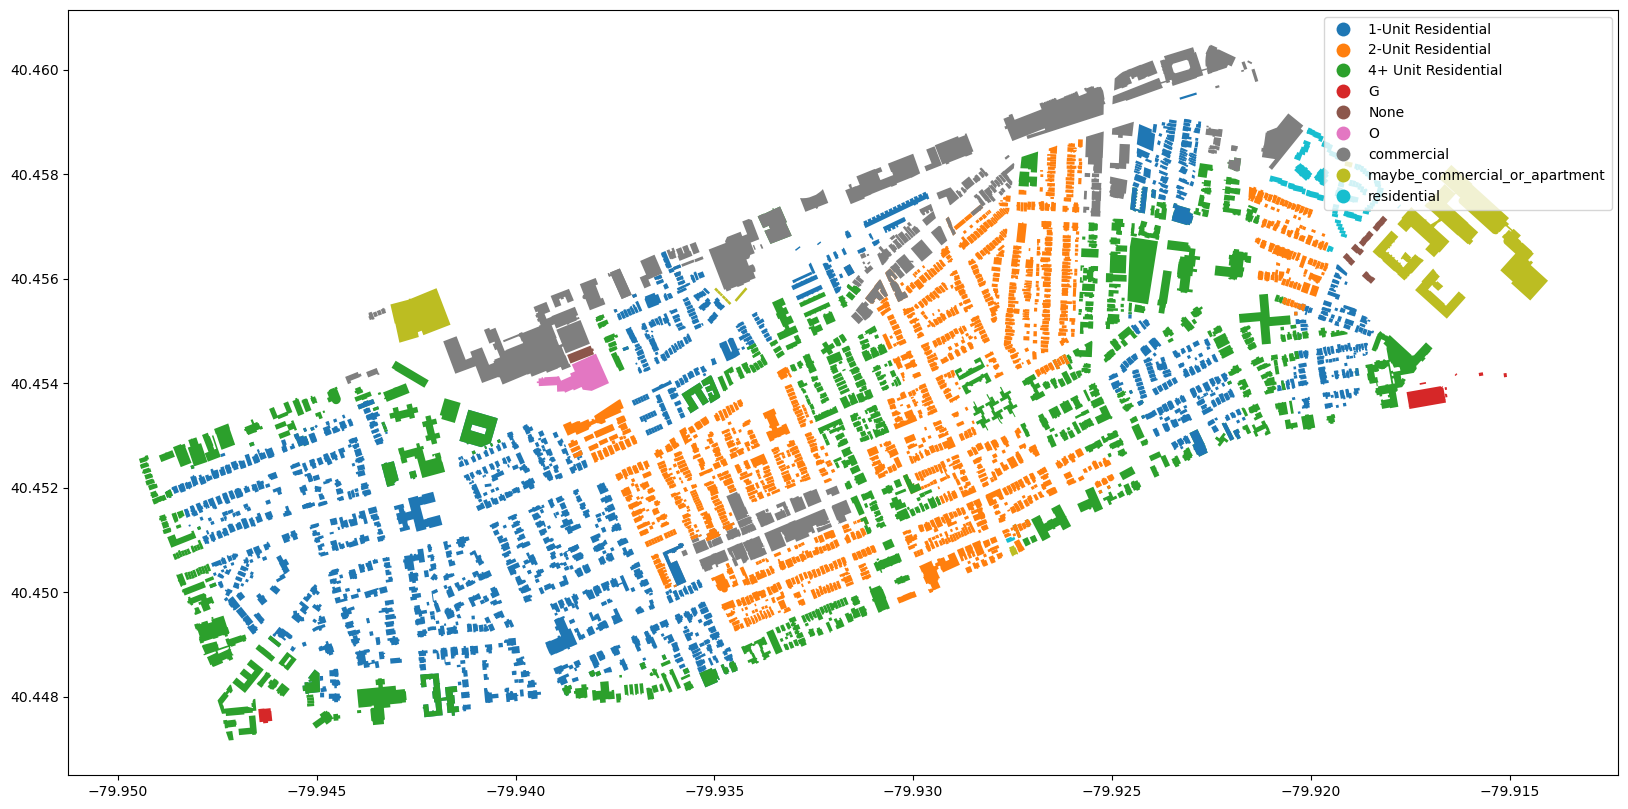

In [6]:
footprint_zones['class_recode'] = footprint_zones['CLASS'] # Base the variable off of class, to begin with
# Note that the recode flags commercial buildings not located in the relevant areas as maybe commercial or apartment
# This is to reflect the ambiguity in the data. Apartments will come later...
footprint_zones.loc[footprint_zones['class_recode'] == 'C', 'class_recode'] = 'maybe_commercial_or_apartment' # start with baseline commercial classification
footprint_zones.loc[footprint_zones['legendtype'].isin(['Local Neighborhood Commercial', 'Highway Commercial', 'Urban Neighborhood Commercial']), 'class_recode'] = 'commercial'
# Next, do residential recodes
footprint_zones.loc[footprint_zones['class_recode'] == 'R', 'class_recode'] = 'residential' # the baseline
footprint_zones.loc[footprint_zones['legendtype'].isin(['Single-Unit Attached Residential','Single-Unit Detached Residential']), 'class_recode'] = '1-Unit Residential'
footprint_zones.loc[footprint_zones['legendtype'].isin(['Two-Unit Residential']), 'class_recode'] = '2-Unit Residential'
footprint_zones.loc[footprint_zones['legendtype'].isin(['Three-Unit Residential']), 'class_recode'] = '3-Unit Residential'
footprint_zones.loc[footprint_zones['legendtype'].isin(['Multi-Unit Residential']), 'class_recode'] = '4+ Unit Residential'


# Let's see shadyside now, for all buildings
plt.rcParams["figure.figsize"]=20,20
shady_all = footprint_zones.loc[(footprint_zones['hood']== 'Shadyside')]
#residential.columns
shady_all.plot(column='class_recode', legend = True)

#### 4. Add grocery store data from the WPRDC
Now I will supplement the above map, which looks okay given my understanding of the neighborhood. There are some misses, it seems. For example the Winchester Thurston School and First Unitarian Church are listed as residential. If we really wanted to we could probably cull these out by supplementing the data, but we are limited by time.

In [7]:
# pittsburgh_footprint_clean.to_file("C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/processed_data/pittsburgh_footprint_clean.shp")
# Get assets table and turn it into something geographic
assets_pre = pd.read_csv('C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/input_data/spatial_data/Allegheny_county_assets.csv')
assets = gpd.GeoDataFrame(
    assets_pre, geometry=gpd.points_from_xy(assets_pre.longitude, assets_pre.latitude)
).set_crs(4326, allow_override=True)
# Get apartments
assets = assets[['name','latitude','longitude','asset_type','geometry','city']]
food = assets.loc[assets['asset_type'].isin(['supermarkets','wic_vendors','food_banks'])]
food

C:\Users\jacar\AppData\Local\Temp\ipykernel_21944\3934256190.py:3: DtypeWarning: Columns (2,7,16,19,20,24,28,29,41) have mixed types. Specify dtype option on import or set low_memory=False.
  assets_pre = pd.read_csv('C:/Users/jacar/OneDrive/Documents/GitHub/Food-Access/input_data/spatial_data/Allegheny_county_assets.csv')


name   latitude  \
175                                  Shop N Save Village  40.365041   
998                                               Target  40.342710   
2702         Giant Eagle #47 / Market District Robinson   40.441638   
3040                                         Giant Eagle  40.451231   
3041                                         Giant Eagle  40.456605   
...                                                  ...        ...   
32933        UPMC Family Care Connection - Lawrenceville  40.481165   
32934  West Mifflin Food Bank @ Walnut Grove Christia...  40.355117   
32935                                 Welcome Little One  40.439559   
32936                         West Allegheny Food Pantry  40.443835   
32937                    Urban League Greater Pittsburgh  40.477581   

       longitude    asset_type                    geometry  \
175   -79.871306   wic_vendors  POINT (-79.87131 40.36504)   
998   -80.053342   wic_vendors  POINT (-80.05334 40.34271)   
2702  -80.151349  supermarkets  POINT (-80.15135 40.44164)   
3040  -80.000951   wic_vendors  POINT (-80.00095 40.45123)   
3041  -79.934365   wic_vendors  POINT (-79.93437 40.45661)   
...          ...           ...                         ...   
32933 -79.954010    food_banks  POINT (-79.95401 40.48116)   
32934 -79.908657    food_banks  POINT (-79.90866 40.35512)   
32935 -80.001769    food_banks  POINT (-80.00177 40.43956)   
32936 -80.240623    food_banks  POINT (-80.24062 40.44383)   
32937 -80.002360    food_banks  POINT (-80.00236 40.47758)   

                      city  
175       Duquesne Village  
998    South Hills Village  
2702            Pittsburgh  
3040           North Shore  
3041            Pittsburgh  
...                    ...  
32933                  NaN  
32934         West Mifflin  
32935                  NaN  
32936             Imperial  
32937           Pittsburgh  

[307 rows x 6 columns]

<AxesSubplot:>

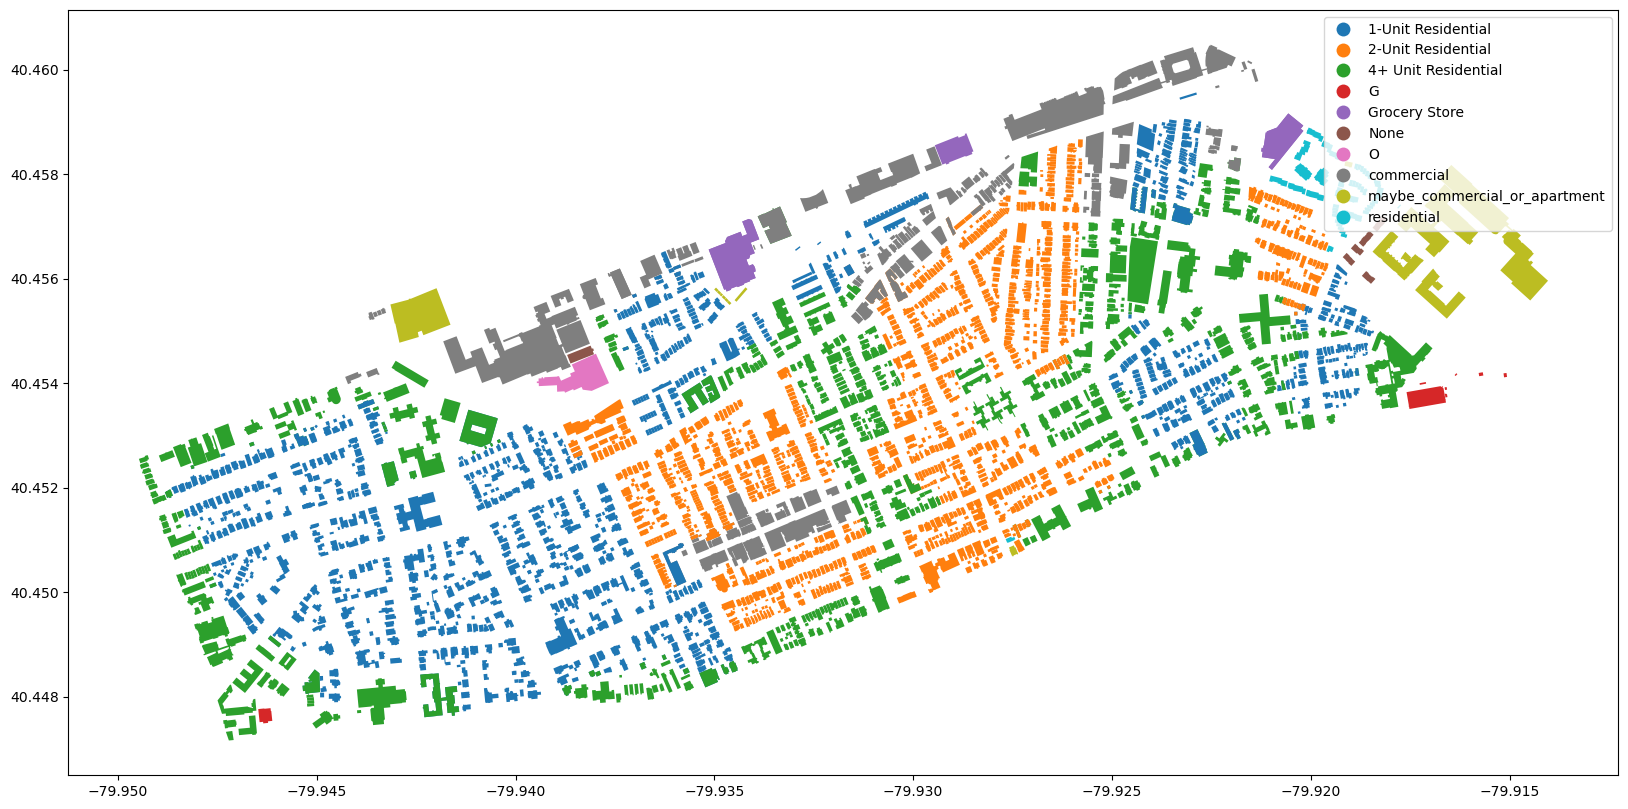

In [13]:
# Maybe we some footprints classified as residential are not residential?
footprint_zones = footprint_zones.drop(columns=['index_right'])
footprint_zones = footprint_zones.sjoin(food, how="left", predicate='intersects')
footprint_zones.loc[footprint_zones['asset_type'].isin(['wic_vendors','food_banks','supermarkets']), 'class_recode'] = 'Grocery Store' # recode to apartments if possible

# Let's see shadyside again, for all buildings
plt.rcParams["figure.figsize"]=20,20
shady_all = footprint_zones.loc[(footprint_zones['hood']== 'Shadyside')]
#residential.columns
shady_all.plot(column='class_recode', legend = True)

#### 5. Clean up shapefile to remove irrelevant structures, recode ambiguous commercial plots to be commercial.

<AxesSubplot:>

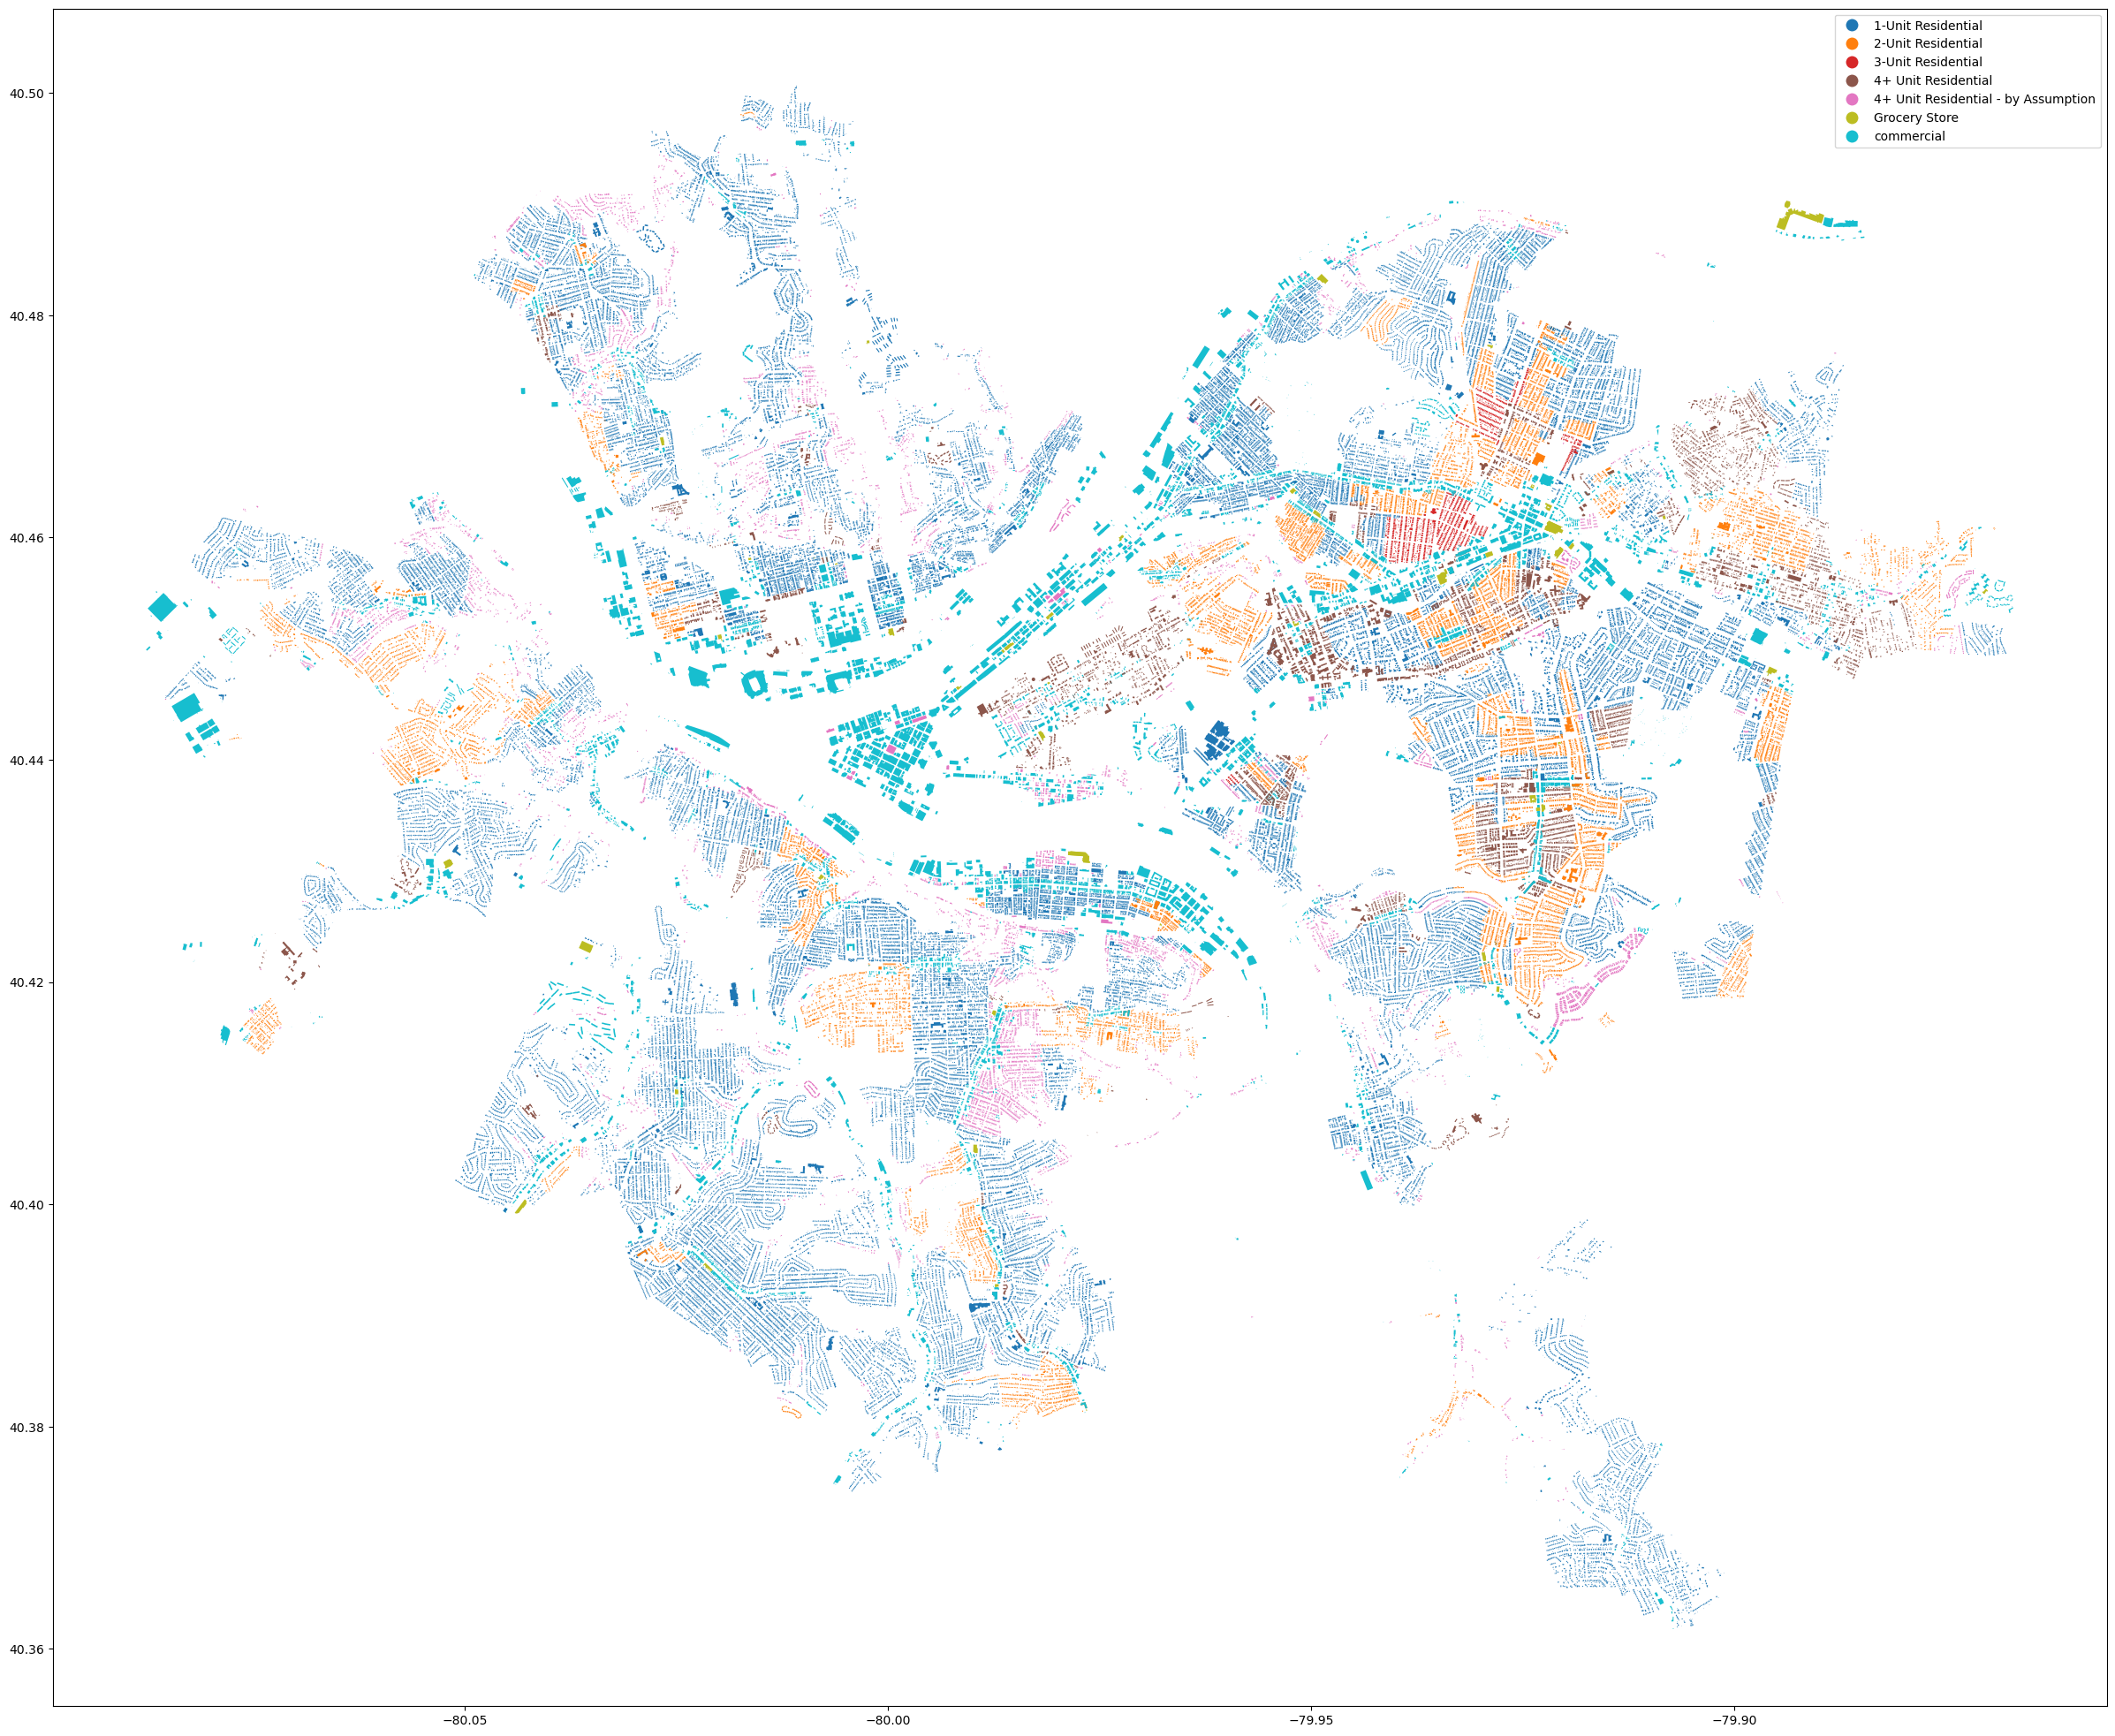

In [15]:
# First recode the maybes to be commercial
footprint_zones.loc[footprint_zones['class_recode'].isin(['maybe_commercial_or_apartment']), 'class_recode'] = 'commercial'
# Next recode the residential ones to be 1 unit buildings to be safe
footprint_zones.loc[footprint_zones['class_recode'].isin(['residential']), 'class_recode'] = '1-Unit Residential'

# Now drop unrelated building types
relevant_buildings = footprint_zones.loc[(footprint_zones['class_recode'].isin(['1-Unit Residential','4+ Unit Residential',
'commercial','Grocery Store','1-Unit Residential','2-Unit Residential','3-Unit Residential']))]

# Let's see shadyside again, for all buildings
plt.rcParams["figure.figsize"]=30,30
#residential.columns
relevant_buildings.plot(column='class_recode', legend = True)

#### 6. Write final file